In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
import copy

### set the seeds and change to current directory + set the output directory

In [14]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [15]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import plotCorr, getPred_fromProb, getMetrics, getCorr, getGroundTruth, getURange
from AnalysisFuncs import getResiduals, plotDistributionProbs, plotCorr_w_Unobs
from AnalysisFuncs import saveFile, loadFile, plotCalibrationPlots

In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk')

In [18]:
train_second_stage = loadFile(osp.join(processed_data_path,'secondStage'),'train_second_stage.pkl')
test_second_stage = loadFile(osp.join(processed_data_path,'secondStage'), 'test_second_stage.pkl')
cal_second_stage = loadFile(osp.join(processed_data_path,'secondStage'), 'cal_second_stage.pkl')
calibrate_method='sigmoid'
test_X = test_second_stage['X_T']
cal_X = cal_second_stage['X_T']
# test_idxs = test_second_stage['idxs']
# cal_idxs = cal_second_stage['idxs']
calibrated_p_T = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_T'), '/probs.npy')
calibrated_p_D_T1 = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_D|T'), '/probs.npy')

553271


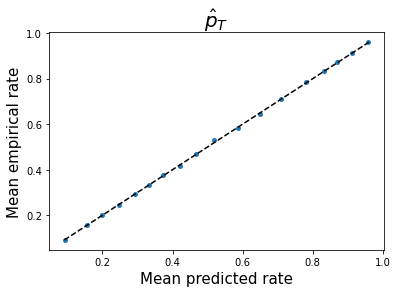

In [22]:
# check that these are indeed the calibrated probabilities 
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_T = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'), '/test_y_T.npy')
plotCalibrationPlots(calibrated_p_T, test_y_T, None, 'T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()
print(len(test_y_T))

311885


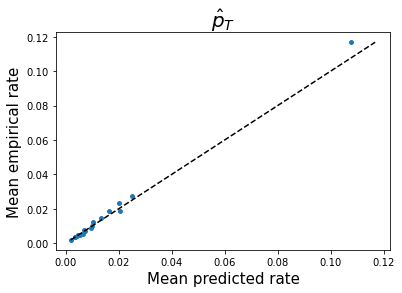

In [23]:
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_D_given_T = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'), '/test_y_D_given_T.npy')
plotCalibrationPlots(calibrated_p_D_T1[test_y_T==1], test_y_D_given_T, None, 'T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()
print(len(test_y_D_given_T))

In [21]:
# load df_cleaned and test_idxs
# features = loadFile(processed_data_path, 'features.pkl')
# df_sf = loadFile(processed_data_path, 'processed_df.csv')
# assert len(np.intersect1d(test_idxs[train_second_stage['idxs']], test_idxs[test_second_stage['idxs']]))==0
tr=len(train_second_stage['idxs'])
t=len(test_second_stage['idxs'])
cal = len(cal_second_stage['idxs'])
print(f"train second stage %:{tr*100/(tr+t+cal):.2f}, test second stage %:{t*100/(tr+t+cal):.2f}")
print(f"len of test second stage:{t}")

train second stage %:50.00, test second stage %:25.00
len of test second stage:138318


In [9]:
# load the models
LGBM_T = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_T'),'LGBM_T.pkl')
LGBM_D_given_T = loadFile(osp.join(processed_data_path,'secondStage', 'predict_D_given_T'),'LGBM_D_given_T.pkl')
LGBM_D_and_T =loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_and_T'),'LGBM_D_and_T.pkl')
LGBM_D_given_T_ipw = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T_ipw'),'LGBM_D_given_T_ipw.pkl')
LGBM_D_pseudo = loadFile(osp.join(processed_data_path, 'secondStage', 'predict_D_pseudo'),'LGBM_D_pseudo.pkl')

 calibrating by bins with cal data
val max:6916, val min:6915
 number of bins in test :20
calibrated_preds
0.106854    0.097875
0.156449    0.156193
0.204020    0.204331
0.255205    0.251621
0.287305    0.299752
0.330393    0.334144
0.370065    0.375292
0.413534    0.412599
0.478456    0.475718
0.524291    0.518454
0.586466    0.580424
0.646038    0.657616
0.706622    0.706302
0.789588    0.769793
0.836611    0.826684
0.877820    0.863936
0.903412    0.903478
0.922209    0.921037
0.942597    0.943019
0.965153    0.964406
Name: ground_truth, dtype: float64
auc_score:0.828
auc_score:0.828
classification report for model LGBM, task T: 
               precision    recall  f1-score   support

           0       0.62      0.62      0.62     60483
           1       0.70      0.71      0.71     77835

    accuracy                           0.67    138318
   macro avg       0.66      0.66      0.66    138318
weighted avg       0.67      0.67      0.67    138318

 calibrating by bins with cal d

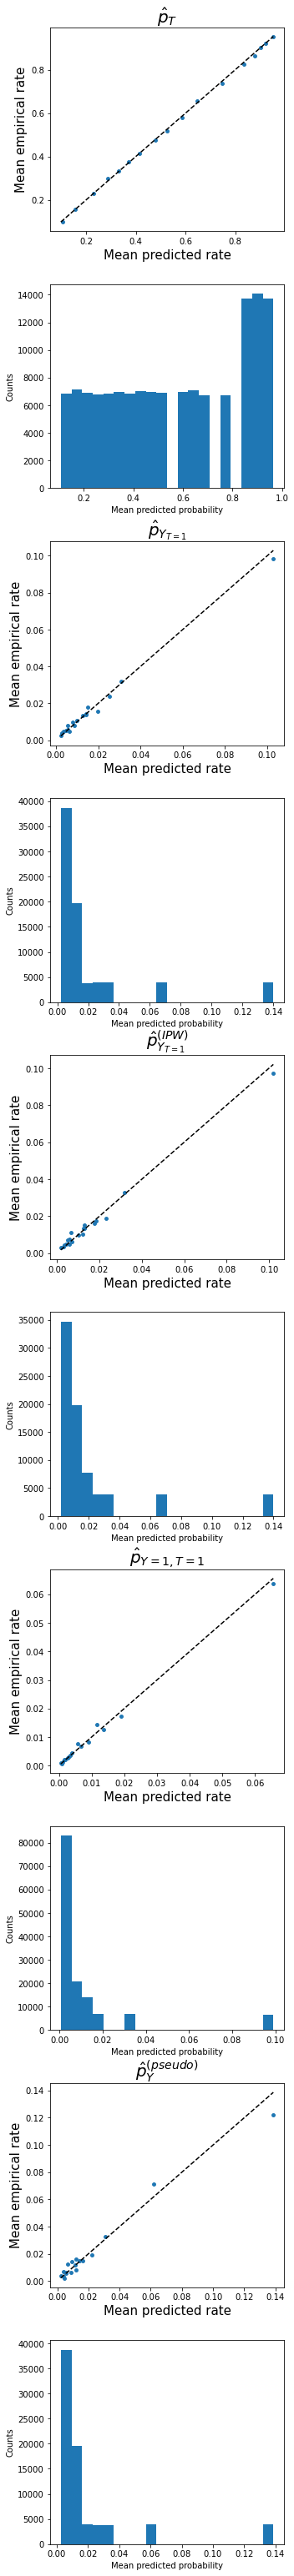

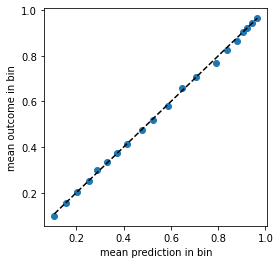

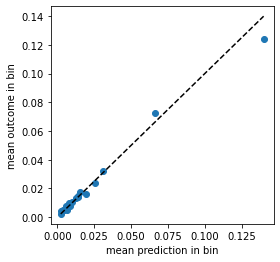

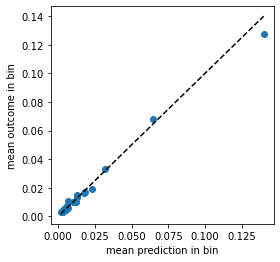

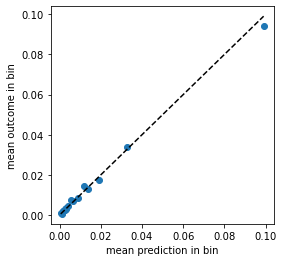

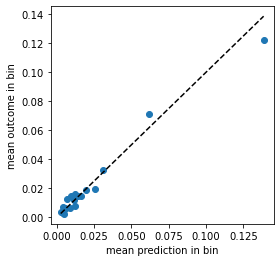

T and D|T probs for model LGBM: (0.28551602485148186, 0.0)
T and D,T probs for model LGBM: (0.41856363198009083, 0.0)
D,T and D|T probs for model LGBM: (0.8585156927653463, 0.0)


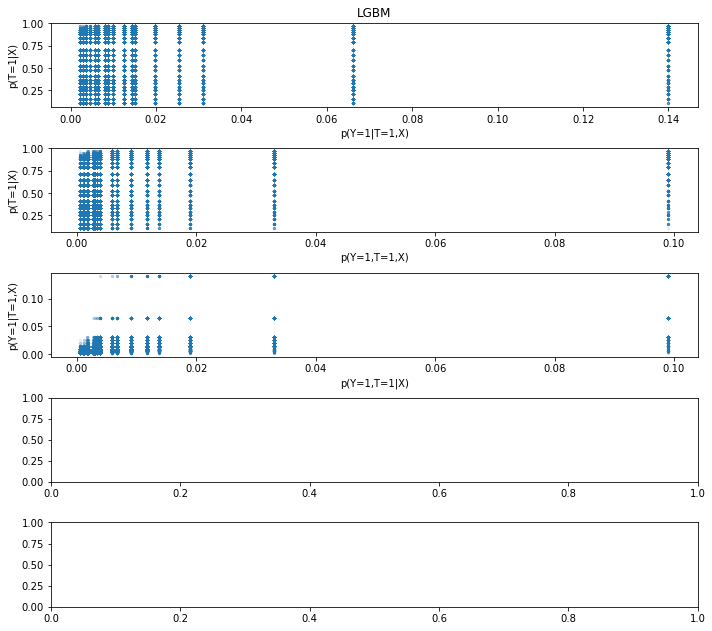

In [10]:
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
clf_list=[LGBM_T, LGBM_D_given_T, LGBM_D_given_T_ipw,
          LGBM_D_and_T, LGBM_D_pseudo]
clf_dict={}
i=0
for t in tasks:
    clf_dict[t]={}
    for m in models:
        clf_dict[t][m]=clf_list[i]
        i+=1
dict_df_labels={}
dict_df_probs={}
dict_df_ids={}
dict_models={}
probs_path=osp.join(processed_data_path, 'secondStage')
alpha=0.1
figsize1=(5,50)
figsize2=(10,10)
df_pp=pd.DataFrame({'AUC' : [],'PR':[],'BalancedAcc':[],'modelName':[],'rowName':[]})
dict_df_labels, dict_df_probs, dict_models, df_pp = getCorr(models, tasks, 
        test_second_stage['X_T'], clf_dict, None, 
        None, dict_df_labels, dict_df_probs, 
        dict_models, df_pp, probs_path, calibrate=True, 
        figsize1=figsize1, figsize2=figsize2, alpha=alpha, test_second_stage=test_second_stage,
        cal_idxs=None, cal_X=cal_X, cal_second_stage=cal_second_stage)


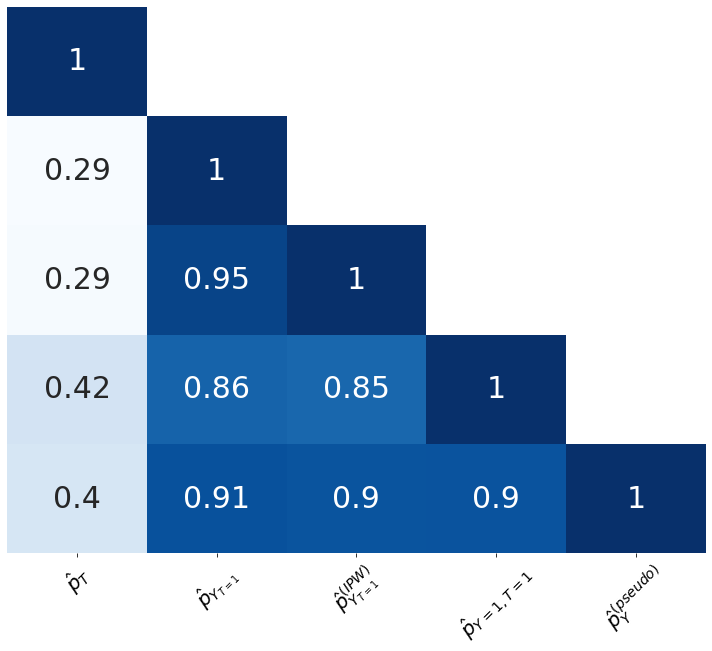

In [11]:
title='Policing correlation matrix'
corr_method="pearson"
figsize=(10, 10)
top_adjust=0.9
title_en=False
plotCorr(models, dict_df_probs, title, corr_method, figsize=figsize, top_adjust=top_adjust,
         title_en=title_en, second_stage=True, savefig_path=osp.join(processed_data_path,'secondStage'))

In [12]:
test_X.shape

(138318, 282)

lines did not cross


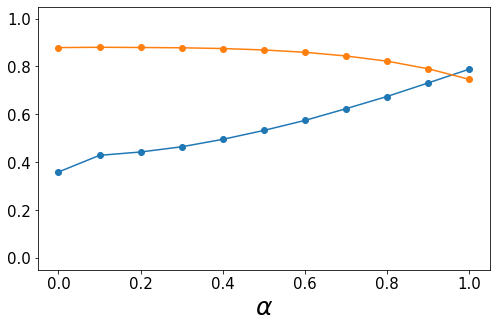

In [13]:
title=r'Policing Correlation with $p_{Y}$ when $u(x)=\alpha p_{Y_{T=1}} all$'
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
tasks=['T', 'D|T']
corr_method=stats.spearmanr
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=np.arange(0,1.1,0.1), corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en,
        calibrated_p_T=calibrated_p_T[test_second_stage['idxs']],
                 calibrated_p_D_T1=calibrated_p_D_T1[test_second_stage['idxs']],
                savefig_path=osp.join(processed_data_path,'secondStage'))

lines did not cross
[[0.99915339 0.37552855]
 [0.37552855 1.00084733]], spearman from lib:SpearmanrResult(correlation=0.3755285528695072, pvalue=0.0), var of D:1587652792.3572156, var of T :1590344455.221596
 the point of crossover would be :0.09482101730867666 with std for p_D_T1:0.026802930930133976 and std for p_T:0.28266867083782443


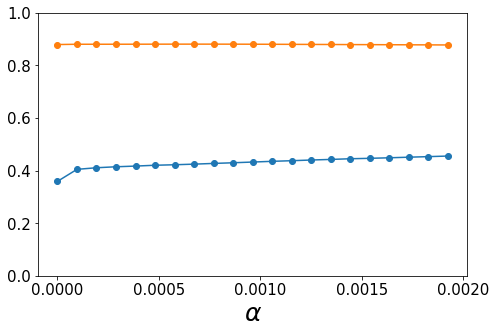

In [14]:
title=r'Policing Correlation with $p_{Y}$ when $u(x)=\alpha$ is constant all'
models=['LGBM']
tasks=['T', 'D|T']
corr_method=stats.spearmanr
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, corr_method=corr_method,
                 figsize=figsize, title_en=title_en,
        calibrated_p_T=calibrated_p_T[test_second_stage['idxs']],
                 calibrated_p_D_T1=calibrated_p_D_T1[test_second_stage['idxs']], custom_ticker=True,
                savefig_path=osp.join(processed_data_path,'secondStage'))

In [15]:
df_probs_stats=pd.DataFrame({'model' : [],'task':[],'mean':[],'std':[], 'min':[]})
for m in models:
    for t in tasks:
        df_probs_stats=df_probs_stats.append({'model' : m,'task':t,'mean':dict_df_probs[m][t].mean(),
                               'std':dict_df_probs[m][t].std(), 'min':dict_df_probs[m][t].min()},ignore_index=True)
        print(f" mean and std for model {m} and task {t}: {dict_df_probs[m][t].mean():.3f}, {dict_df_probs[m][t].std():.3f}")

 mean and std for model LGBM and task T: 0.565, 0.283
 mean and std for model LGBM and task D|T: 0.016, 0.027


In [16]:
df_probs_stats

,model,task,mean,std,min
0,LGBM,T,0.564696,0.282670,0.106854
1,LGBM,D|T,0.016195,0.026803,0.002302


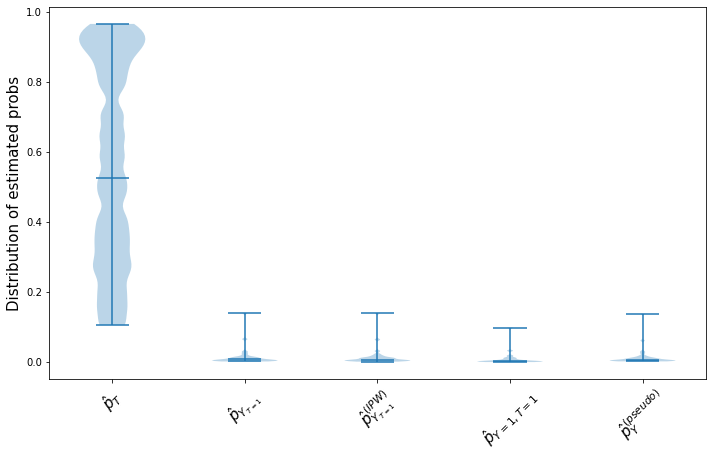

In [17]:
title='Distribution of estimated probs'
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'D_pseudo']
figsize=(10,7)
plotDistributionProbs(dict_df_probs, models, title, tasks, figsize=figsize)

for model :LGBM


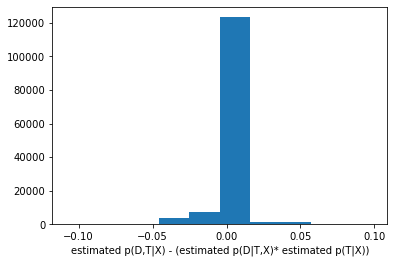

In [18]:
for m in models:
    print(f"for model :{m}")
    getResiduals(dict_df_probs[m]['D_and_T'], dict_df_probs[m]['D|T'], dict_df_probs[m]['T'])